## Background

House price has always been an serious social issue in Taiwan, especially in Taipei city. The nation-wide house price to income ratio revealed by Taiwanese government is around 8.62 in 2020(**[1]**). For Taipei city is around 14.39. If we compare these values with Demographia International Housing Affordability Survey 2019(**[2]**), it's not hard to realize that this such a high number. 

Therefore, I would like to build a regression model trying to predict the housing price in Taipei city, the capital city of Taiwan. Not only to predict the housing price, I also would like to find out what affect housing price the most influentially. Hope the analysis could give us some insight into the cause of present house price problem in Taiwan.

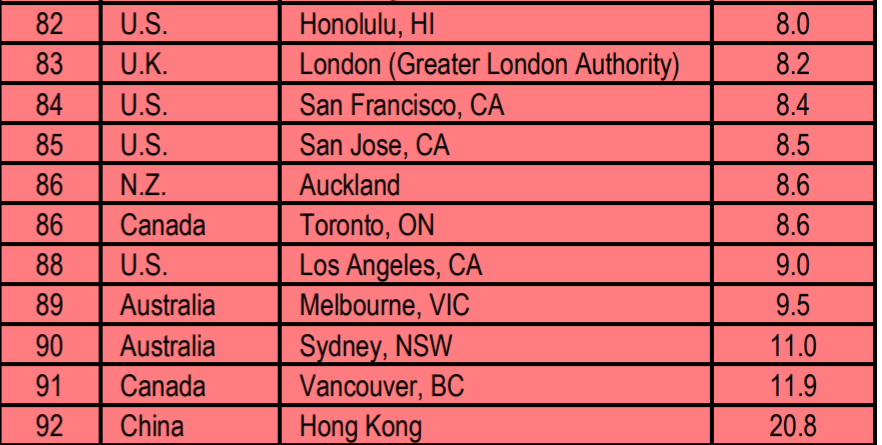

## About Dataset

 This dataset is downloaded from Kaggle(**[3]**). This dataset contains some useful information about recent real estate transaction in Taipei city, the original data mainly comes from open data of Ministry of the Interior of Taiwan(**[4]**).

#### Before importing our dataset of desired, we have to import necessary Python modules

In [37]:
import pandas as pd
import numpy as np
import csv 
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

#### Now let's import our dataset and check the first few rows with head method.

In [38]:
#We import dataset as "Resident_Dataset" which we already filtered out other data not for resident use.
Resident_Dataset = pd.read_csv('2020_H2_Resident_ENG.csv')
Shape = Resident_Dataset.shape

#Let's see how the dataset looks like
Resident_Dataset.head()

,district,transaction type,land shifting total area,transaction year,num_building,num_land,num_garage,total floor number,building state,main building materials,...,management org,carpark type,carpark shifting area,carpark total price,main building area,subsidiary building area,balcony area,elevator,total ntd,unit ntd
0,Wenshan District,Land+Building,1261.30,108,1,3,0,1.0,House,Reinforced Concrete,...,0,No carpark,0.0,0,245.48,0.00,0.00,0,523060000,2130764
1,ZhongZheng District,Land+Building,36.00,109,1,2,0,5.0,Apartment_5storey,Reinforced Concrete,...,0,No carpark,0.0,0,106.57,4.81,16.47,0,18500000,130273
2,ZhongZheng District,Land+Building,19.39,109,1,2,0,7.0,Apartment_5to10storey,Reinforced Concrete,...,0,No carpark,0.0,0,50.17,0.00,5.05,1,21580000,253972
3,ZhongZheng District,Land+Building,10.66,109,1,1,0,5.0,Apartment_5storey,Strengthened Brickwork,...,0,No carpark,0.0,0,33.00,1.63,0.00,0,10400000,300318
4,ZhongZheng District,Land+Building,45.00,109,1,1,0,4.0,Apartment_5storey,Strengthened Brickwork,...,0,No carpark,0.0,0,99.86,0.00,0.00,0,35800000,358502


## Data Cleaning and Feature Engineering

#### In this cell, we transform some of the column into quantity per unit land or building.
#### Also, we do some feature engineering to create some new features for later analysis.

In [39]:
#We do not take transaction data with 0 room into consideration
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_room"]!=0]

In [40]:
#This line create building age at transaction
Resident_Dataset["building age at transaction"] = Resident_Dataset['transaction year'] - Resident_Dataset['complete year']

#This line create unit price without carpark price included
Resident_Dataset["total ntd nocarpark"] = Resident_Dataset["total ntd"] - Resident_Dataset["carpark total price"]

#This line create main building ratio by taking main building area over building shifting total area
Resident_Dataset["main building ratio"] = Resident_Dataset["main building area"] / Resident_Dataset["building shifting total area"]

#Finally, we drop some columns that is no longer of our interest
Resident_Dataset.drop(columns=["carpark total price", "num_garage", "carpark shifting area", "carpark type", "transaction year", "complete year", "total ntd","unit ntd"], inplace = True)
Resident_Dataset.head()

,district,transaction type,land shifting total area,num_building,num_land,total floor number,building state,main building materials,building shifting total area,num_room,num_bathroom,compartment,management org,main building area,subsidiary building area,balcony area,elevator,building age at transaction,total ntd nocarpark,main building ratio
1,ZhongZheng District,Land+Building,36.00,1,2,5.0,Apartment_5storey,Reinforced Concrete,142.01,3,2,1,0,106.57,4.81,16.47,0,33.0,18500000,0.750440
2,ZhongZheng District,Land+Building,19.39,1,2,7.0,Apartment_5to10storey,Reinforced Concrete,84.97,2,1,1,0,50.17,0.00,5.05,1,7.0,21580000,0.590444
4,ZhongZheng District,Land+Building,45.00,1,1,4.0,Apartment_5storey,Strengthened Brickwork,99.86,3,2,1,0,99.86,0.00,0.00,0,51.0,35800000,1.000000
6,Wanhua District,Land+Building+Garage,4.46,1,1,24.0,Apartment_11storeyorgreater,Reinforced Concrete,97.18,1,1,1,1,33.95,3.15,3.22,1,1.0,11950000,0.349352
7,Wanhua District,Land+Building+Garage,4.57,1,1,24.0,Apartment_11storeyorgreater,Reinforced Concrete,75.59,2,1,1,1,35.45,2.61,3.75,1,1.0,12100000,0.468977


In [41]:
#According to common sense, it is abnormal for a single building to have more than 6 rooms and bathrooms
#Thus we filter out data not within this range.
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_room"]/Resident_Dataset["num_room"] <= 6]
Resident_Dataset = Resident_Dataset[Resident_Dataset["num_bathroom"]/Resident_Dataset["num_bathroom"]<= 6]

#### In this cell, we check if there are duplicated rows and found that there are 48 duplicated rows

In [42]:
#We use duplicated method to find out duplicated rows and print our results
num_duplicated = sum(Resident_Dataset.duplicated(keep = "first"))
print("There are " + str(num_duplicated) + " duplicated rows in this dataset")

#Then, we update our dataset to no duplicate one
Resident_Dataset = Resident_Dataset[~Resident_Dataset.duplicated(keep = "first")]
display(Resident_Dataset.head())

#Check again to see if there are duplicates
num_duplicated = sum(Resident_Dataset.duplicated(keep = "first"))
print("There are " + str(num_duplicated) + " duplicated rows in this dataset after cleaning")

There are 44 duplicated rows in this dataset


,district,transaction type,land shifting total area,num_building,num_land,total floor number,building state,main building materials,building shifting total area,num_room,num_bathroom,compartment,management org,main building area,subsidiary building area,balcony area,elevator,building age at transaction,total ntd nocarpark,main building ratio
1,ZhongZheng District,Land+Building,36.00,1,2,5.0,Apartment_5storey,Reinforced Concrete,142.01,3,2,1,0,106.57,4.81,16.47,0,33.0,18500000,0.750440
2,ZhongZheng District,Land+Building,19.39,1,2,7.0,Apartment_5to10storey,Reinforced Concrete,84.97,2,1,1,0,50.17,0.00,5.05,1,7.0,21580000,0.590444
4,ZhongZheng District,Land+Building,45.00,1,1,4.0,Apartment_5storey,Strengthened Brickwork,99.86,3,2,1,0,99.86,0.00,0.00,0,51.0,35800000,1.000000
6,Wanhua District,Land+Building+Garage,4.46,1,1,24.0,Apartment_11storeyorgreater,Reinforced Concrete,97.18,1,1,1,1,33.95,3.15,3.22,1,1.0,11950000,0.349352
7,Wanhua District,Land+Building+Garage,4.57,1,1,24.0,Apartment_11storeyorgreater,Reinforced Concrete,75.59,2,1,1,1,35.45,2.61,3.75,1,1.0,12100000,0.468977


There are 0 duplicated rows in this dataset after cleaning


#### Then, we check if there is NaN or Null values
Result shows there are only 3 columns are with NaN or Null value, and proportion of it are all less than 1%

In [43]:
#We build a dataframe to exhibit the percentage of NaN or Null value 
NAN_Rate = pd.DataFrame(data={"% of NAN":Resident_Dataset.isna().sum()/Shape[0],"% of Null":Resident_Dataset.isnull().sum()/Shape[0]})
NAN_Rate[NAN_Rate["% of NAN"]!=0]

,% of NAN,% of Null
total floor number,0.001427,0.001427
main building materials,0.000204,0.000204
building age at transaction,0.058494,0.058494


#### Subsequently, we remove those rows with NaN or Null since it only occupies less than 1 % of the dataset

In [44]:
for cols in list(Resident_Dataset.columns):
    Resident_Dataset = Resident_Dataset[~Resident_Dataset[cols].isna()]

print("Shape of Resident_Dataset is now " + str(Resident_Dataset.shape))

Shape of Resident_Dataset is now (8476, 20)


#### Now, we would first observe the distribution of numerical variables

First extract numerical columns from original dataset based on column data type. In this step, we also abandoned some numerical columns that is considered discrete and non-quatitative variable. There are 12 different numerical features in our dataset. 

In [45]:
#We create a table listing data types of all columns 
#and pick up numerical ones based on their data type
Type_Table = pd.DataFrame(data={"dtype":Resident_Dataset.dtypes})
Numerical_Columns = list(Type_Table[Type_Table["dtype"] != "object"].index)

#Remove column management_org in numerical cloumns because it's dummy variable type numerical
#Remove transaction year,month and complete year because they are discrete and non-quatitative variables
try:
    Numerical_Columns.remove("management org")
    Numerical_Columns.remove("elevator")
    Numerical_Columns.remove("total ntd nocarpark")
    Numerical_Columns.remove("compartment")
except:
    pass

#Report results of numerical columns
print("We have " + str(len(Numerical_Columns))+" numerical features.")
print("Numerical Columns are :\n" + str(Numerical_Columns))

We have 12 numerical features.
Numerical Columns are :
['land shifting total area', 'num_building', 'num_land', 'total floor number', 'building shifting total area', 'num_room', 'num_bathroom', 'main building area', 'subsidiary building area', 'balcony area', 'building age at transaction', 'main building ratio']


Second, we visualize the distribution of numerical variables using histogram. \
You can see there are a lot of right skewed distribution.

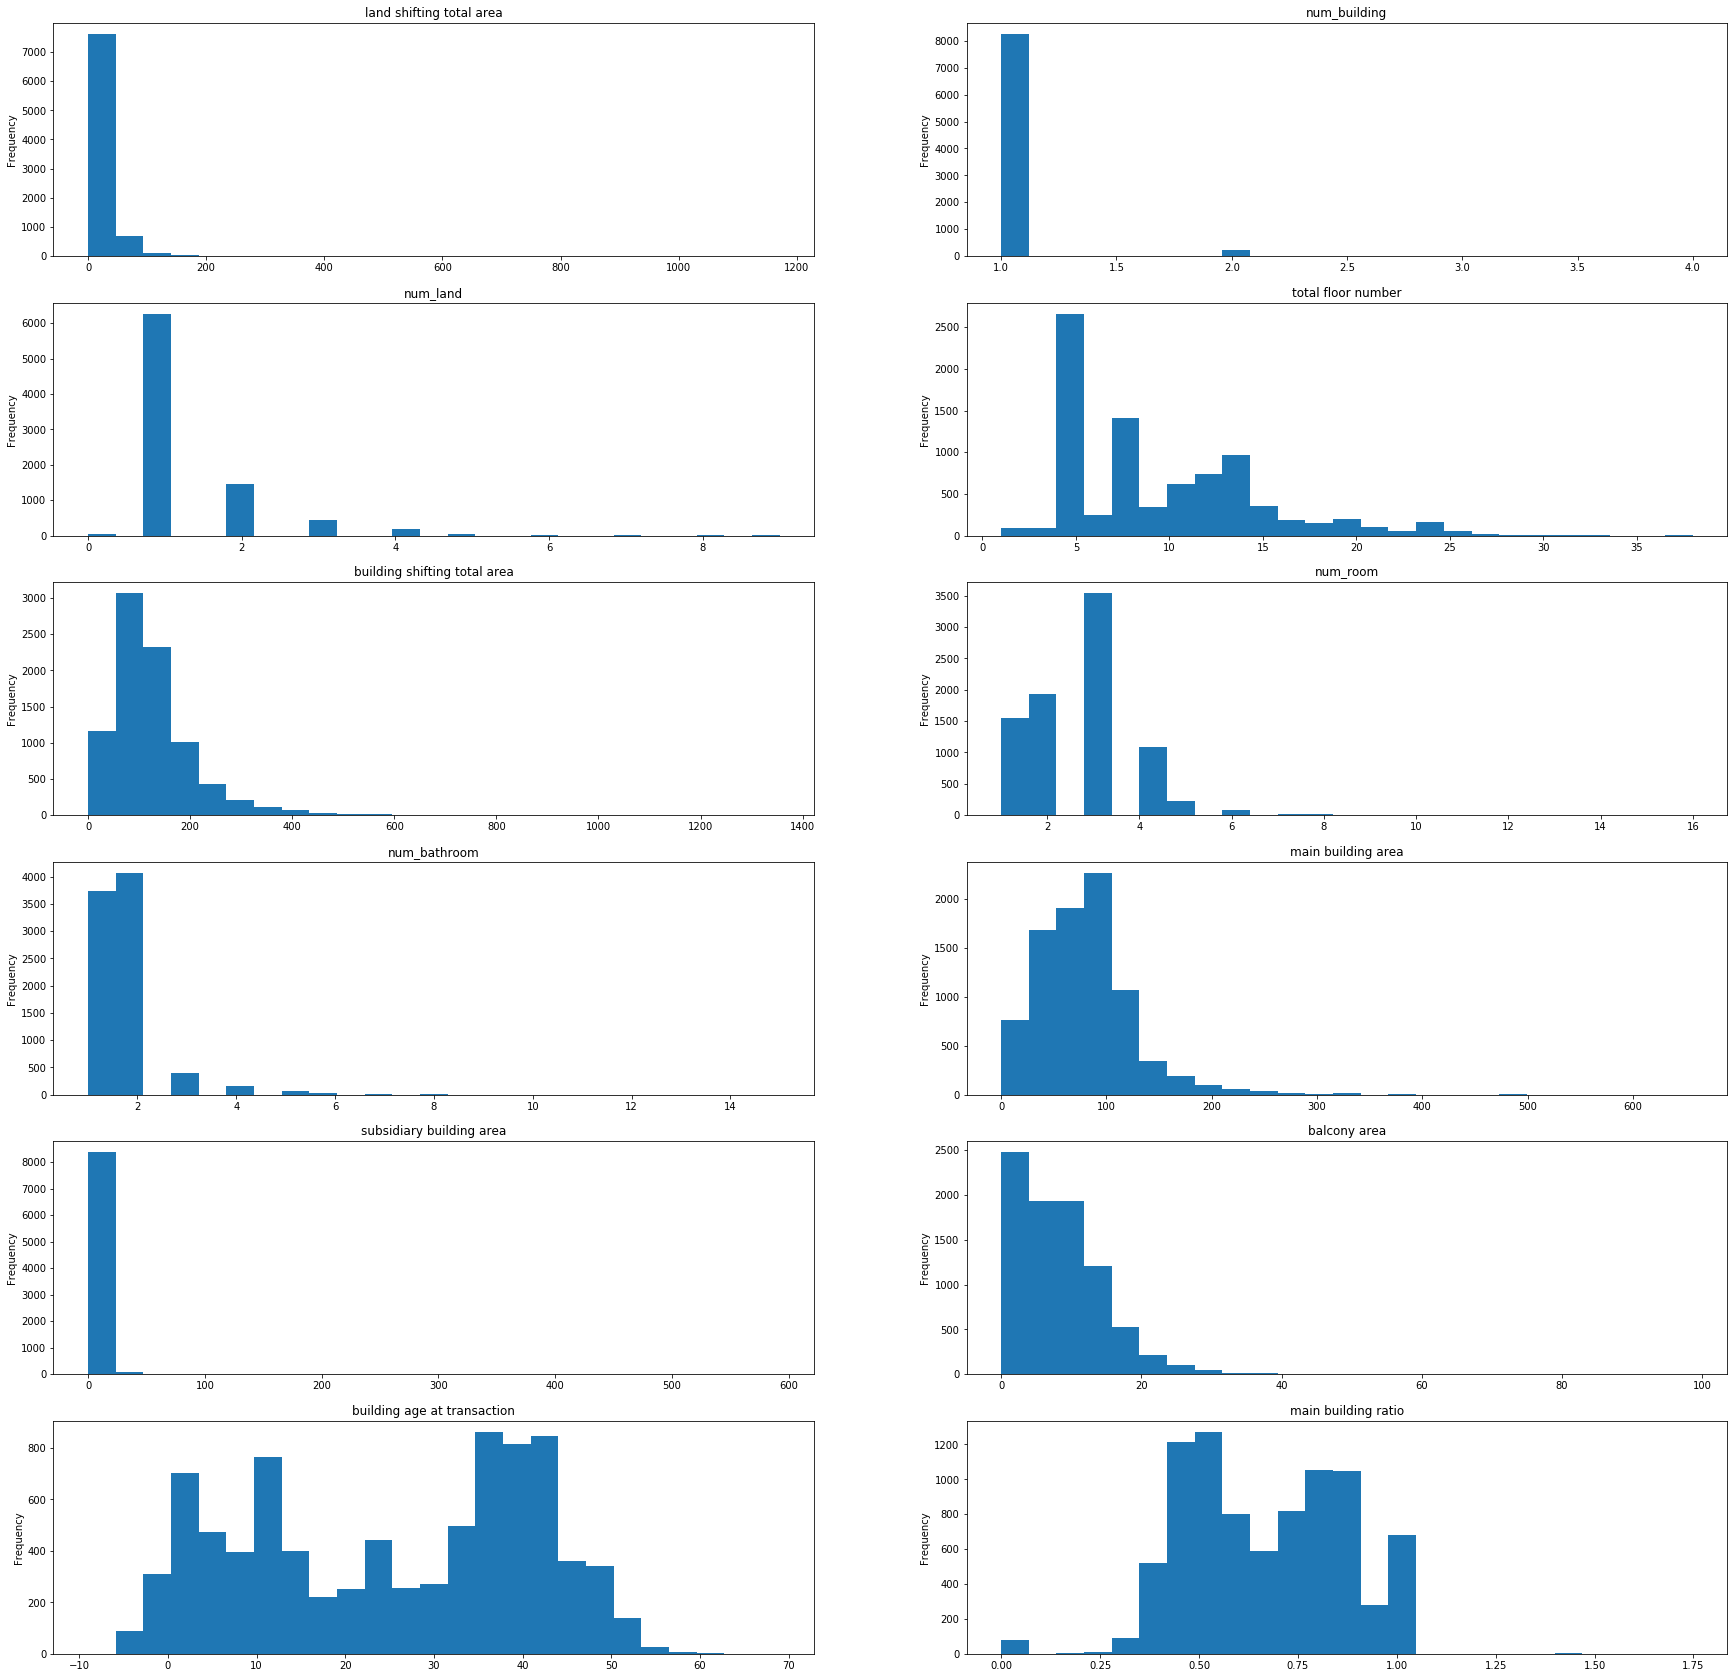

In [46]:
fig = plt.figure(figsize = [30,30])
sub_ind = 1
for cols in Numerical_Columns:
    Resident_Dataset[cols].plot.hist(ax = plt.subplot(6,2,sub_ind), bins = 25, title = cols)
    sub_ind += 1

#### This cell creates a  statistical table listing 6 standard deviation and 1.5IQR information. We will reference the table to eliminate data points that is not considered normal condition at all.

In [47]:
Num_Max = []
Num_min = []
mean_lst = []
stdup = []
stdlow = []
IQRup = []
IQRlow = []
for cols in Numerical_Columns:
    mean = Resident_Dataset[cols].mean()
    std = Resident_Dataset[cols].std()
    Q1 = Resident_Dataset[cols].quantile(0.25)
    Q3 = Resident_Dataset[cols].quantile(0.75)
    mean_lst.append(mean)
    stdup.append(mean + 3*std)
    stdlow.append(mean - 3*std)
    IQR = Q3 - Q1
    Num_Max.append(Resident_Dataset[cols].max())
    Num_min.append(Resident_Dataset[cols].min())
    IQRup.append(Q3 + 1.5*IQR)
    IQRlow.append(Q1 - 1.5*IQR)

Numerical_Columns_Stats = pd.DataFrame({"Feature":Numerical_Columns,"Max":Num_Max,"min":Num_min,"IQRup":IQRup,"IQRlow":IQRlow,"Mean":mean_lst,"stdup":stdup,"stdlow":stdlow})
Numerical_Columns_Stats.index = Numerical_Columns_Stats["Feature"]
Numerical_Columns_Stats.drop(columns = ["Feature"], inplace = True)
Numerical_Columns_Stats

,Max,min,IQRup,IQRlow,Mean,stdup,stdlow
Feature,,,,,,,
land shifting total area,1171.000000,0.00,64.040000,-16.86000,27.837752,123.633237,-67.957732
num_building,4.000000,1.00,1.000000,1.00000,1.027135,1.542141,0.512130
num_land,9.000000,0.00,3.500000,-0.50000,1.407739,4.182248,-1.366769
total floor number,38.000000,1.00,25.000000,-7.00000,9.547664,25.715602,-6.620274
building shifting total area,1355.120000,0.01,274.536250,-42.59375,126.821641,372.288299,-118.645017
num_room,16.000000,1.00,4.500000,0.50000,2.653374,6.179702,-0.872954
num_bathroom,15.000000,1.00,3.500000,-0.50000,1.693841,4.186844,-0.799162
main building area,656.980000,0.00,181.810000,-33.25000,79.823964,218.097011,-58.449083
subsidiary building area,592.210000,0.00,8.375000,-5.02500,3.040329,33.226364,-27.145705


#### We scan through numerical rows and cut off data point with value greater than limitation defined by 1.5IQR method.

In [48]:
clean_columns = ["land shifting total area", "building shifting total area", "main building area", "subsidiary building area", "balcony area"]
for cols in clean_columns:   
    threshold = Numerical_Columns_Stats.loc[cols,"IQRup"]
    Resident_Dataset = Resident_Dataset[Resident_Dataset[cols] < threshold]

Resident_Dataset.shape

(7096, 20)

#### In this cell, we further clean the dataset according to our prediction goal (unit ntd nocarpark)
We would like to remove some extreme data of unit_ntd column because these values may not reflect normal housing t
transaction behavior compared to those inside our range of interest.

We will apply 1.5\*IQR method filter our data. After filtration, you can see the close to symmetry distribution of unit ntd nocarpark

Text(0.5, 1.0, 'Distribution of Unit ntd after cutting 2% data')

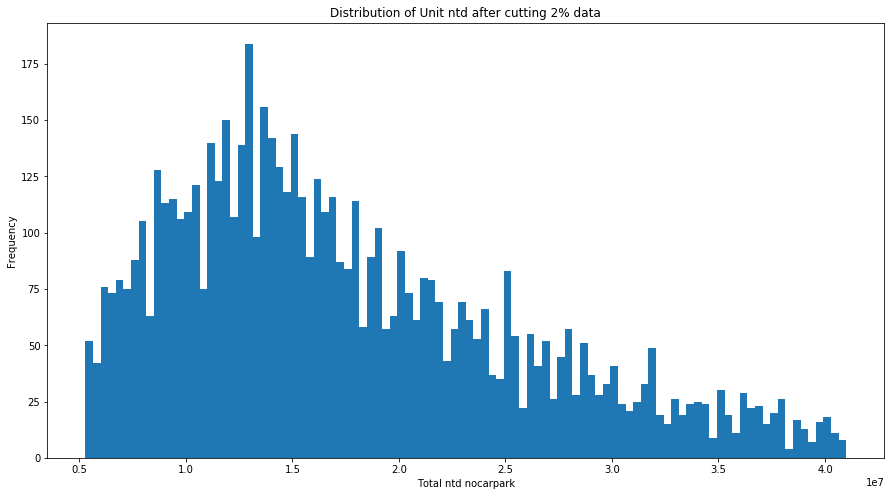

In [49]:
#In order to get a more general model that can fit non-extreme cases,
#We will abandon first and last 1% of data after sorting with unit ntd.

percent_1 = Resident_Dataset.shape[0]*0.05
Resident_Dataset = Resident_Dataset.sort_values(by=['total ntd nocarpark']).iloc[int(percent_1):-int(percent_1),:]

plt.figure(figsize = [15,8])
plt.hist(Resident_Dataset["total ntd nocarpark"], bins = 100)
plt.xlabel("Total ntd nocarpark")
plt.ylabel("Frequency")
plt.title("Distribution of Unit ntd after cutting 2% data")


## Feature Selection

#### We first select features for our numerical dataset
Before that, we import necessary libraries for later regression

In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV,RFE
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### This cell creates table for numerical variables

In [51]:
#Create numerical table
Numerical_Table = Resident_Dataset[Numerical_Columns]
Numerical_Table.head()

,land shifting total area,num_building,num_land,total floor number,building shifting total area,num_room,num_bathroom,main building area,subsidiary building area,balcony area,building age at transaction,main building ratio
7167,11.76,1,1,6.0,41.00,1,1,26.74,0.0,3.43,28.0,0.652195
6122,25.20,2,1,5.0,109.79,3,1,85.54,0.0,14.58,37.0,0.779124
2657,3.85,1,1,12.0,31.25,1,1,21.25,0.0,3.72,39.0,0.680000
7522,22.93,1,1,6.0,113.49,3,2,84.96,0.0,13.67,39.0,0.748612
5444,4.19,1,1,10.0,36.87,1,1,25.33,0.0,3.58,41.0,0.687008


,total ntd nocarpark
total ntd nocarpark,1.000000
building shifting total area,0.770659
main building area,0.524759
balcony area,0.362200
num_room,0.341717
num_bathroom,0.325415
land shifting total area,0.287686
total floor number,0.252788
subsidiary building area,0.240636
building age at transaction,0.228284


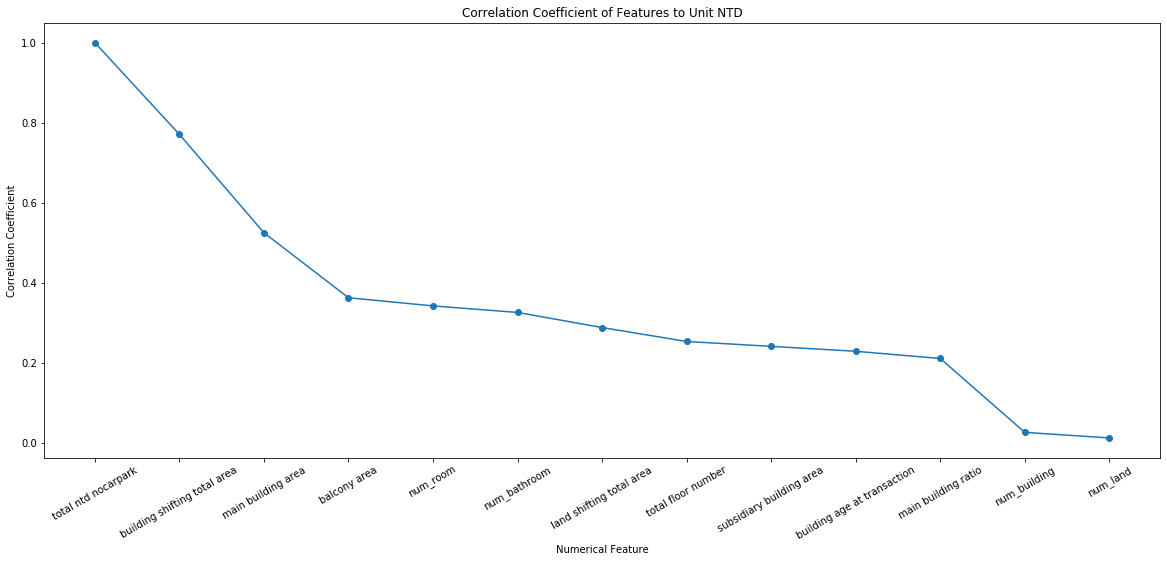

In [52]:
Numerical_Table2 = pd.concat([Numerical_Table,Resident_Dataset["total ntd nocarpark"]],axis=1)
Numerical_Corr = pd.DataFrame(abs(Numerical_Table2.corr()["total ntd nocarpark"])).sort_values(by="total ntd nocarpark",ascending=False)

display(Numerical_Corr)


plt.figure(figsize = [20,8])
plt.xticks(rotation = 30)
plt.xlabel("Numerical Feature")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Coefficient of Features to Unit NTD")
plt.plot(Numerical_Corr, marker = 'o') 

Numerical_Columns2 = list(Numerical_Corr[Numerical_Corr["total ntd nocarpark"]>0.2].index)
Numerical_Columns2.remove("total ntd nocarpark")

del Numerical_Table2

#### We then convert categorical data into dummy variables
Before this, we first briefly inspect the number of different categories in each categorical variable.

In [53]:
Categorical_Unique = {"Categorical_Variable":[],"Unique_Values":[]}
Categorical_Columns = []
for cols in list(Resident_Dataset.columns):
    if cols not in Numerical_Columns and cols != "total ntd nocarpark":
        Categorical_Columns.append(cols)
        Categorical_Unique["Categorical_Variable"].append(cols)
        Categorical_Unique["Unique_Values"].append(len(Resident_Dataset[cols].unique()))
Categorical_Unique_Table = pd.DataFrame(Categorical_Unique)
Categorical_Unique_Table

,Categorical_Variable,Unique_Values
0,district,12
1,transaction type,3
2,building state,8
3,main building materials,9
4,compartment,1
5,management org,2
6,elevator,2


#### Before turning these variables into dummy variable, we look briefly at the number of unique labels within  the variable

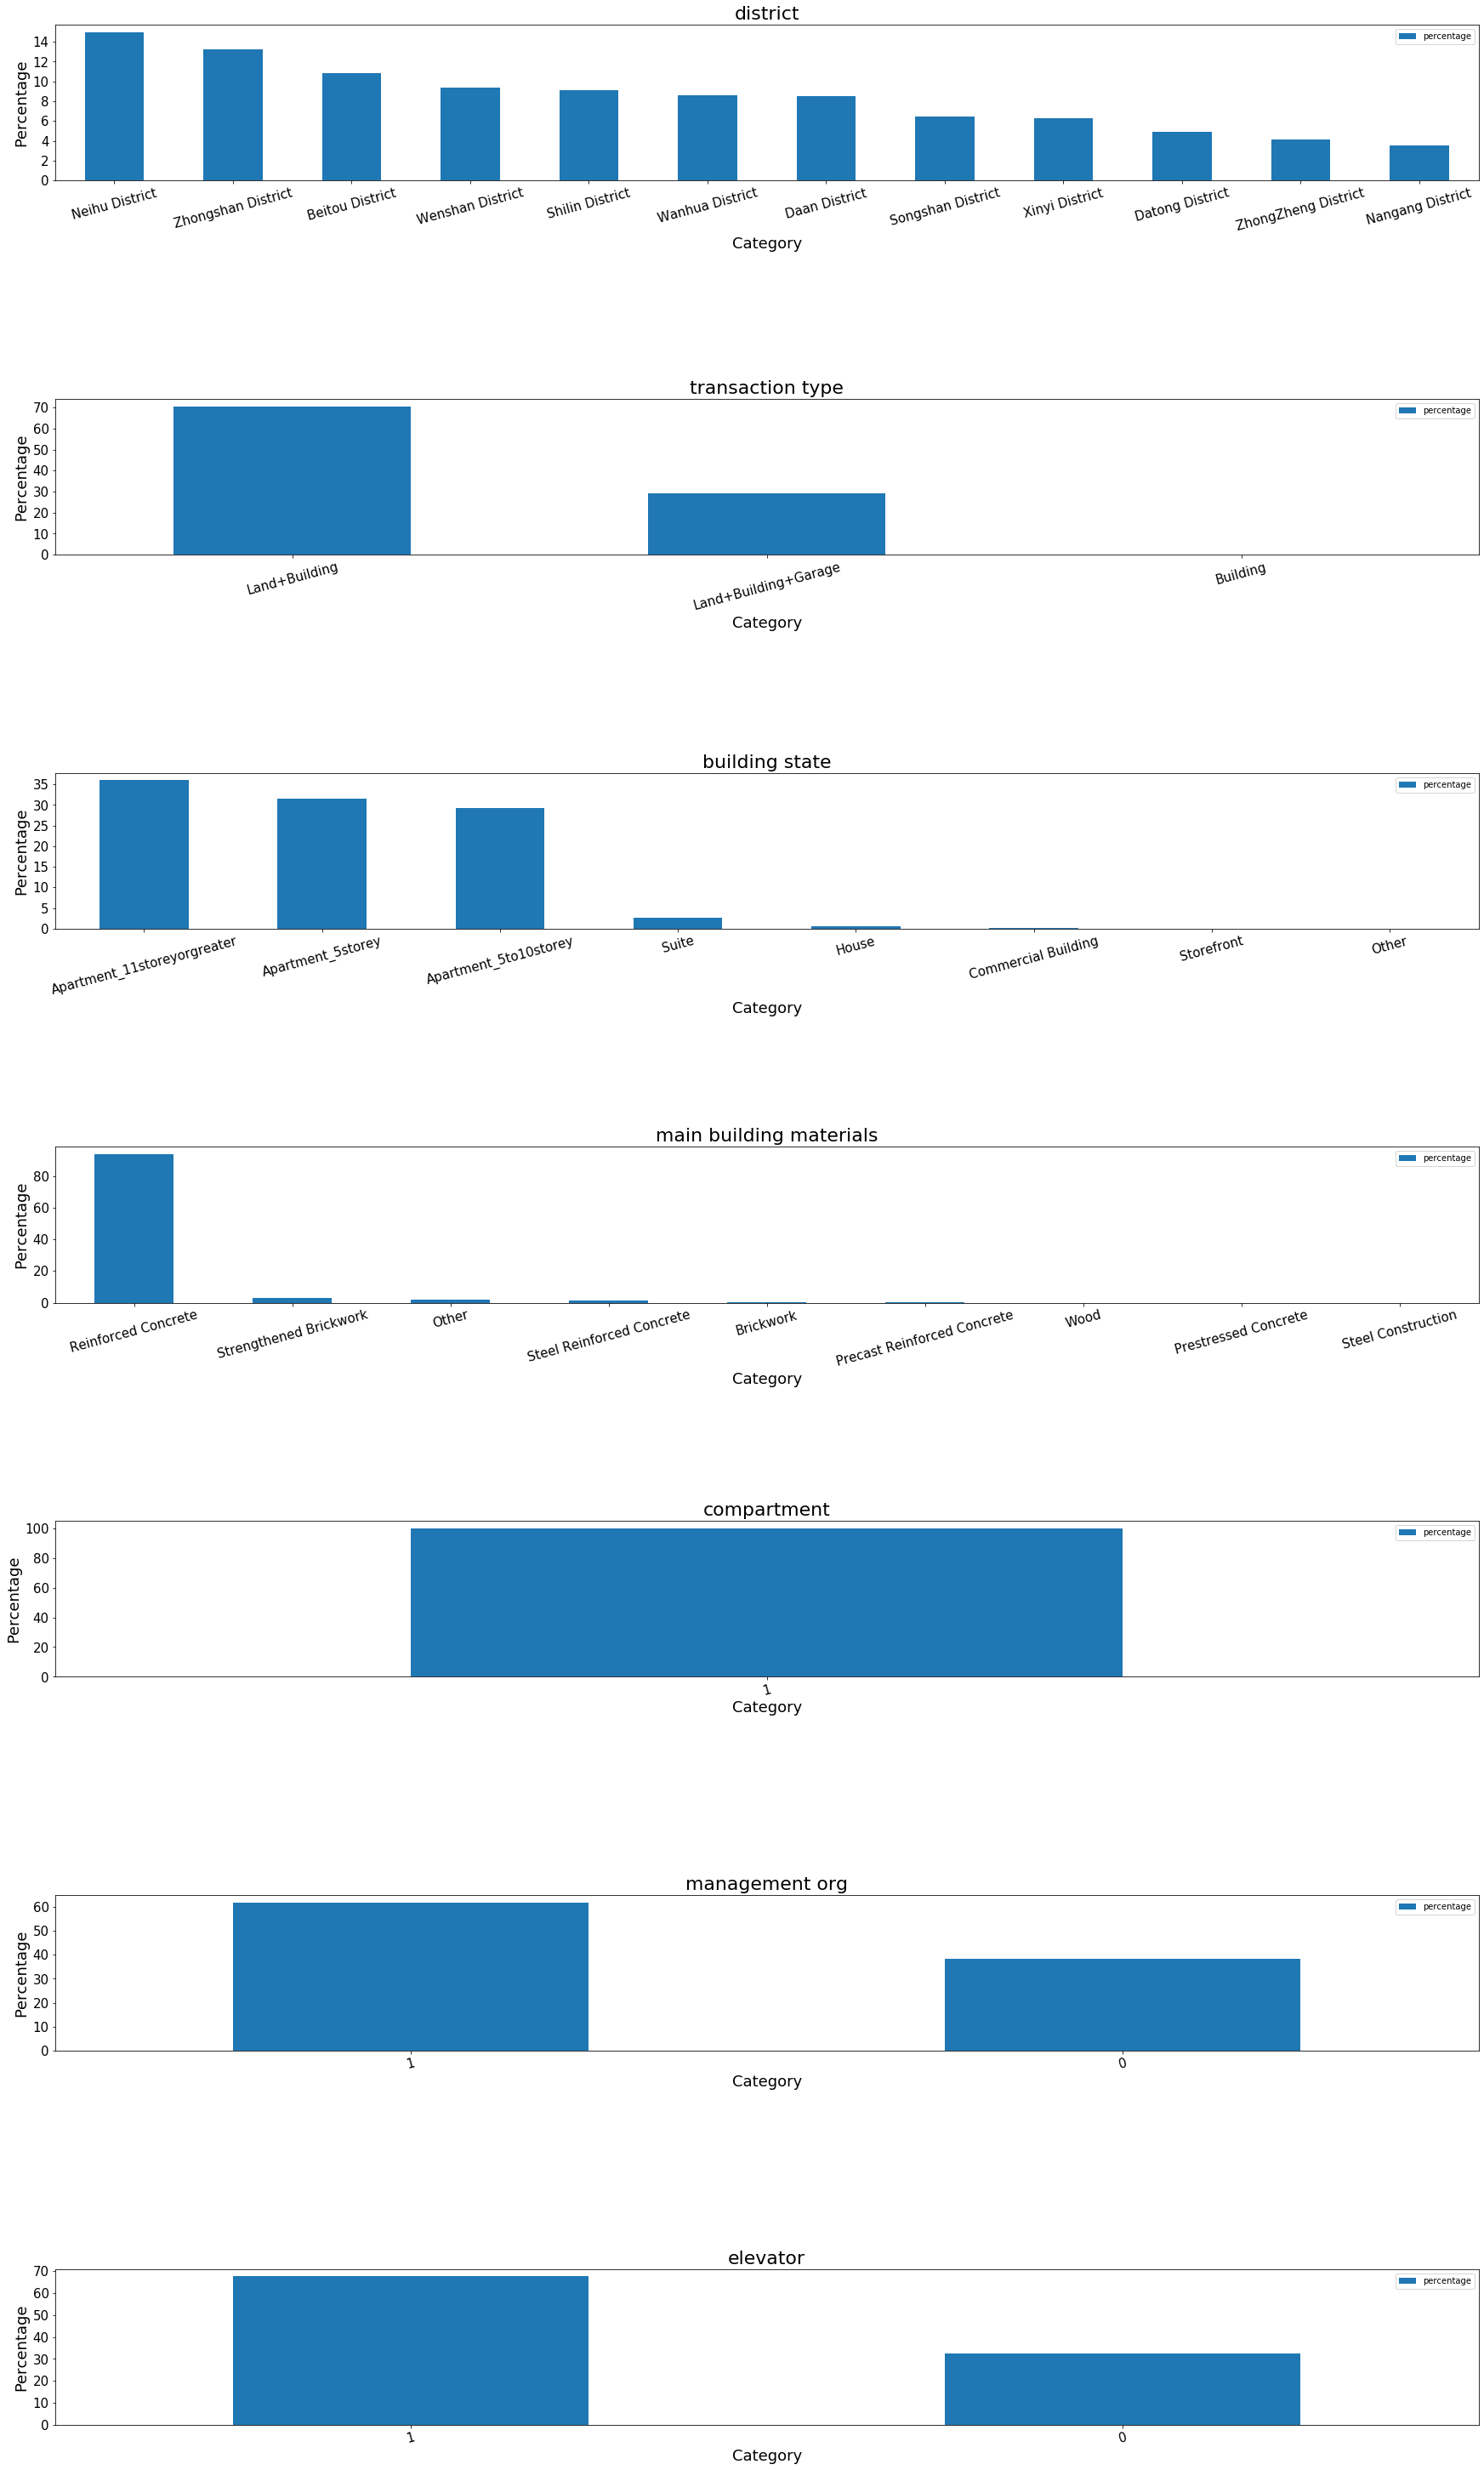

In [54]:
data_num = Resident_Dataset.shape[0]
fig2,ax2 = plt.subplots(figsize = [30,60])   
ind = 1

Proportion_Dict = {}
   
for var in Categorical_Columns:
    Temp_DF = pd.DataFrame(Resident_Dataset[var].value_counts()).reset_index()
    Temp_DF.insert(0,"variable",[var]*Temp_DF.shape[0])
    Temp_DF.columns = ["variable","category","percentage"]
    Temp_DF["percentage"] = Temp_DF["percentage"]/data_num*100
    Temp_DF.set_index(["variable","category"],inplace=True)
    for cats in list(Resident_Dataset[var].unique()):
        if var not in Proportion_Dict.keys():
            Proportion_Dict[var] = {}
        Proportion_Dict[var][cats] = Temp_DF.loc[var,cats]
        
    Temp_DF.loc[var].plot(kind="bar", ax = plt.subplot(15,1,ind),title=var,fontsize=15)
    plt.xticks(rotation=15)
    plt.xlabel("Category",fontsize = 18)
    plt.ylabel("Percentage",fontsize = 18)
    plt.title(var,fontsize=22)
    ind+=2


In [55]:
#In this cell, we will do some feature engineering on categories in features having too few samples. 
#Because this kind of transformation cannot provide effective behavior and may harm the regression 
#algorithm  

#Create a new dataset to store data for later regression
Categorical_Dataset = pd.DataFrame()

#For feature transaction_type, we will omit the category "building" and "garage" because they 
#occupied only a very minor part. Also, the concept of these two types are as well exhibited by 
#categories.
exclusion = ["management org","elevator","compartment"]
for var in Categorical_Columns:
    if var not in exclusion:
        Categorical_Dataset = pd.concat([Categorical_Dataset,pd.get_dummies(Resident_Dataset[var],prefix = var)], axis = 1, sort = False)
        for cats in Proportion_Dict[var].keys():
            value = float(Proportion_Dict[var][cats])
            if value < 1:
                Categorical_Dataset.drop(columns = [str(var) + "_" + str(cats)], inplace = True)
    else:
        Categorical_Dataset[var] = Resident_Dataset[var]
        
Categorical_Dataset

,district_Beitou District,district_Daan District,district_Datong District,district_Nangang District,district_Neihu District,district_Shilin District,district_Songshan District,district_Wanhua District,district_Wenshan District,district_Xinyi District,...,building state_Apartment_5storey,building state_Apartment_5to10storey,building state_Suite,main building materials_Other,main building materials_Reinforced Concrete,main building materials_Steel Reinforced Concrete,main building materials_Strengthened Brickwork,compartment,management org,elevator
7167,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,1,1
6122,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
2657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1
7522,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
5444,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1
1441,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,1
8134,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,1,1
8170,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,1


#### Finally, we concatenate categorical and numerical dataset as our final dataset for regression

In [56]:
Dataset = pd.concat([Categorical_Dataset,Resident_Dataset[Numerical_Columns2]], axis = 1)
Dataset.head(5)

,district_Beitou District,district_Daan District,district_Datong District,district_Nangang District,district_Neihu District,district_Shilin District,district_Songshan District,district_Wanhua District,district_Wenshan District,district_Xinyi District,...,building shifting total area,main building area,balcony area,num_room,num_bathroom,land shifting total area,total floor number,subsidiary building area,building age at transaction,main building ratio
7167,0,0,0,0,1,0,0,0,0,0,...,41.00,26.74,3.43,1,1,11.76,6.0,0.0,28.0,0.652195
6122,0,0,0,0,0,0,0,1,0,0,...,109.79,85.54,14.58,3,1,25.20,5.0,0.0,37.0,0.779124
2657,0,0,0,0,0,0,0,0,0,0,...,31.25,21.25,3.72,1,1,3.85,12.0,0.0,39.0,0.680000
7522,0,0,0,0,0,0,0,0,0,0,...,113.49,84.96,13.67,3,2,22.93,6.0,0.0,39.0,0.748612
5444,0,0,0,0,0,0,0,0,0,0,...,36.87,25.33,3.58,1,1,4.19,10.0,0.0,41.0,0.687008


#### The last step, we perform VIF(variance_inflation_factor) analysis to reduce the affect of colinearity to our predictive model

In [57]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Retrieve initial column list
column = list(Dataset.columns)
Temp_Dataset = Dataset.copy()

#Iterate until all VIFs are less than 10(typical value)
VIF_safe = False

while VIF_safe == False:
    vif_table = pd.DataFrame()
    vif_table["Features"] = column
    vif_table["VIF"] = [variance_inflation_factor(Temp_Dataset.values, i) for i in range(Temp_Dataset.shape[1])]
 
    #Handle inf values
    if sum(vif_table["VIF"] == np.inf) >0:
        column.remove(list(vif_table[vif_table["VIF"] == np.inf]["Features"])[0])
        Temp_Dataset = Temp_Dataset[column]
        
    #Handle VIF greater than 10
    elif sum(vif_table["VIF"] > 10) > 0:
        vif_table.sort_values(by=["VIF"], ascending = False, inplace = True)
        column.remove(list(vif_table["Features"])[0])
        Temp_Dataset = Temp_Dataset[column]
        
    #All VIFs are less than 10, set VIF_safe = True
    else: 
        VIF_safe = True
    
#delete Temp_Numerical_Table
del Temp_Dataset

#Assign numerical columns to the result after VIF analysis
Dataset = Dataset[column]

display(vif_table)

C:\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Features,VIF
0,district_Daan District,1.663409
1,district_Datong District,1.288482
2,district_Nangang District,1.262991
3,district_Neihu District,2.057105
4,district_Shilin District,1.656866
5,district_Songshan District,1.506674
6,district_Wanhua District,1.471339
7,district_Wenshan District,1.676802
8,district_Xinyi District,1.432929
9,district_ZhongZheng District,1.261344


## Regression

#### We first divide our dataset into training and test set using train_test_split method in Scikit-Learn. Then, we apply Ordinary Least Square (OLS) method in statsmodel.api module and remove some features with higher P value (indicating that the feature is possibly not significant)

In [58]:
#import statsmodel.api module
import statsmodels.api as sm
from  sklearn.metrics import r2_score

#Adding intercept term for dataset
Dataset["intercept"] = 1

#Divide whole dataset into x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(Dataset,Resident_Dataset["total ntd nocarpark"],test_size=0.3,random_state = 1)

#Fit the data with ordinary least square method
LR_OLS = sm.OLS(y_train, x_train)
LR_OLS_result = LR_OLS.fit()

#We try to remove data column with relatively high p value to see if we can get better result(threshold 0.01)
P_table = pd.DataFrame(LR_OLS_result.pvalues)
P_table.columns = ["P value"]
Dataset = Dataset[P_table[P_table["P value"]<0.05].index]

In [59]:
Metrics_Table = pd.DataFrame(index = ["LR_OLS_TRAIN","LR_OLS_TEST","LR_OLS_R1","LR_OLS_R2","LR_OLS_R3","LR_OLS_R4","LR_OLS_R5"],\
                             columns = ["R squared", "RMSE"])

Metrics_Table.loc["LR_OLS_TRAIN","R squared"] = LR_OLS_result.rsquared
Metrics_Table.loc["LR_OLS_TEST","R squared"] = r2_score(y_test,LR_OLS_result.predict(x_test))
Metrics_Table.loc["LR_OLS_TRAIN","RMSE"] = np.sqrt(mean_squared_error(LR_OLS_result.predict(x_train),y_train))
Metrics_Table.loc["LR_OLS_TEST","RMSE"] = np.sqrt(mean_squared_error(LR_OLS_result.predict(x_test),y_test))

Coef_Table = pd.DataFrame(index = list(Dataset.columns))
Metrics_Table

,R squared,RMSE
LR_OLS_TRAIN,0.595289,5.25296e+06
LR_OLS_TEST,0.585844,5.14402e+06
LR_OLS_R1,NaN,NaN
LR_OLS_R2,NaN,NaN
LR_OLS_R3,NaN,NaN
LR_OLS_R4,NaN,NaN
LR_OLS_R5,NaN,NaN


In [60]:
for i in range(1,6):
    x_train1, x_test1, y_train1, y_test1 = train_test_split(Dataset, Resident_Dataset["total ntd nocarpark"], test_size=0.3, random_state = i)
    LR_OLS2 = sm.OLS(y_train1, x_train1)
    LR_OLS2_result = LR_OLS2.fit()
    Metrics_Table.loc["LR_OLS_R" + str(i), "R squared"] = LR_OLS2_result.rsquared
    Metrics_Table.loc["LR_OLS_R" + str(i), "RMSE"] = np.sqrt(mean_squared_error(LR_OLS2_result.predict(x_test1),y_test1))
    Coef_Table["LR_OLS_R" + str(i) + "_Coef"] = list(LR_OLS2_result.params)

In [61]:
Coef_Table["LR_OLS_AVG"] = Coef_Table.mean(axis = 1)

#### We then use iterative gradient descent to do the linear regression

## Reference
1. https://pip.moi.gov.tw/V3/E/SCRE0105.aspx
2. http://www.demographia.com/dhi.pdf
3. https://www.kaggle.com/chrischien17/taiwan-taipei-city-real-estate-transaction-records
4. https://plvr.land.moi.gov.tw/DownloadOpenData